# Investigating the results of analysing mrna data

The aim of this analysis is to implement a fully Bayesian version of the main statistical model featured in the paper 

> Liepe, Kirk, Filippi, Toni, Barnes, Stumpf (2014) A Framework for Parameter Estimation and Model Selection from Experimental Data in Systems Biology Using Approximate Bayesian Computation, Nature protocols.

The original analysis describes mrna self-regulation using the following kinetic model:

![](./data/raw/model.png)

This kinetic model can be expressed mathetmatically in the following equations, which were copied from the supplementary file `mRNAselfReg1.sbml`:

\begin{align}
S &=
  \left[ {\begin{array}{ccccccc}
    -1 & 0 & 1 & 0 & 0 & -1 & -1\\
    1 & -1 & 0 & 0 & -1 & 0 & 0\\
    0 & 1 & 0 & -1 & 0 & 0 & 0
  \end{array} } \right] \\
v &= 
  \left[ {\begin{array}{c}
   p_0 \cdot m \\
   p_1 \cdot P1 \\
   p_2 \cdot P1 \\
   p_4 \cdot P2 \\
   p_4 \cdot P1 \\
   p_4 \cdot m \\
   p_3 \cdot P2 \cdot m
  \end{array} } \right] \\
\frac{d[m,P1,P2]}{dt} &= S \cdot v
\end{align}

The original analysis simulates a synthetic timecourse for the species $m$ given known starting concentrations, defines prior distributions for the parameters $p_0,\ldots,p_4$ and uses an approximate Bayesian computation (ABC) method to generate a large number of prior realisations assuming the same starting concentrations, rejecting any that are far away from the generated timecourse. The resulting ensemble of prior realisations are then taken as an approximation to a posterior distribution that takes into account information from both the synthetic measurements and the provided priors, but without the need to explicitly write down this distribution's measurement model.

There are several problems with this approach when applied to real kinetic modelling applications. First, it might be important to represent information about the measurement process in the statistical model: for example, it might be known within an order of magnitude how accurate the measurements were. However this is impossible without an explicit measurement model. Second, the non-rejected region of parameter space becomes relatively smaller as this space's dimensionality increases, with the result that ABC methods are limited to  problems involving small numbers of parameters. Finally, diagnostic tools for ABC are not as well developed as for other Bayesian computation methods such as Markov Chain Monte Carlo.

For these reasons it is generally preferable, where possible, to analyse a kinetic system using a statistical model with an explicit likelihood function instead of ABC. This is what this analysis attempts to do. First we implement a fully Bayesian statistical model matching the original analysis as closely as possible, then we analyse another fully Bayesian model that makes some changes to the original analysis.

## Prior model

The original analysis treats the parameter $p_4$ as known exactly (with the value 1) and for the other parameters uses uniform prior distributions with a lower bound at zero and the following upper bounds (see the supplementary data file `input_file1.xml`):

| parameter | upper bound| 
|------------ | ---|
|$p_0$| 50 |
|$p_1$| 10 |
|$p_2$| 50 |
|$p_3$| 10 |

## Measurement model

To model measurements of the species $m$ we use a lognormal regression with unknown error parameter $\sigma$. In other words, given parameters implying that the true value of $m$ is $\hat{m}$ we expect the measured value $y_m$ to follow the following proability density:

\begin{equation}
y_m\sim LN(\ln{\hat{m}}, \sigma)
\end{equation}

This choice of measurement model is motivated by the assumption that the errors of the measurement apparatus will roughly scale with the size of the measured quantity.

## ODE function

In order to represent the kinetic model using Stan we have to write down a function for the rate of change of the three species with respect to time, given current values and parameters. This is a straightforward representation of the expression for $\frac{d[m,P1,P2]}{dt}$ shown above, complicated only by a check to exclude negative concentrations.

In [1]:
!cat src/stan/custom_functions.stan

/* This file is for your stan functions */

vector dPdt(real time, vector c, matrix S, vector p){
  vector[3] c_min_zero;
  for (i in 1:3){
    c_min_zero[i] = c[i] < 0 ? 0 : c[i];
  }
  return S * [p[1] * c_min_zero[1],
              p[2] * c_min_zero[2],
              p[3] * c_min_zero[2],
              p[5] * c_min_zero[3],
              p[5] * c_min_zero[2],
              p[5] * c_min_zero[1],
              p[4] * c_min_zero[3] * c_min_zero[1]]';
}


# Full model

The Stan program reproducing the original analysis is shown in the next cell.

In [2]:
!cat src/stan/liepe.stan

/* Model that attempts to copy the one in Liepe et al */
functions {
#include custom_functions.stan
}
data {
  int<lower=1> N;
  int<lower=1> N_train;
  int<lower=1> N_test;
  array[2] real sigma_loc_and_scale;
  vector[4] p_upper_bounds;
  vector[N] y_m;
  array[N] real sim_times;
  array[N_train] int<lower=1,upper=N> ix_train;
  array[N_test] int<lower=1,upper=N> ix_test;
  int<lower=0,upper=1> likelihood;
}
transformed data {
  matrix[3, 7] S = [[-1, 0, 1, 0, 0,-1,-1],
                    [ 1,-1, 0, 0,-1, 0, 0],
                    [ 0, 1, 0,-1, 0, 0, 0]];
  vector[3] conc_init = [10, 5, 0]';
  real t_init = 0;
  real abstol = 1e-12;
  real reltol = 1e-12;
  int steps = 1000000;
}
parameters {
  real<lower=0> sigma;
  vector<lower=0>[4] p_unknown;
}
transformed parameters {
  vector[5] p = append_row(p_unknown, 1);
  array[N] vector[3] conc =
    ode_bdf_tol(dPdt, conc_init, t_init, sim_times, abstol, reltol, steps, S, p);
}
model {
  sigma ~ lognormal(sigma_loc_and_scale[1], sigma_

In [3]:
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

RESULTS_DIR = os.path.join("results", "runs")
ARVIZ_STYLE = "arviz-redish"

## Loading model results

In [4]:
liepe_prior, liepe_posterior = (
    az.from_json(os.path.join(RESULTS_DIR, "liepe", f))
    for f in ["prior.json", "posterior.json"]
)


The next cell shows a summary of the prior-only fit. The main things to note is that the chains have not converged, as the `r_hat` value for all parameters of interest is far from 1, and that there were a lot of post-warmup divergent transitions (approximately 99%).

The divergent transitions are likely caused by the choice of uniform priors for the $p$ parameters. Since the uniform distribution has a sharp change in density at its boundaries which can causes discretisation errors for Hamiltonian Monte Carlo samplers. Since, in the prior model, there is no information available that can guide the sampler away from these boundaries, such errors are likely to happen a lot.

In [5]:
pd.concat([
    az.summary(liepe_prior, var_names=["sigma", "p"]),
    az.summary(liepe_prior.sample_stats)
])

/Users/tedgro/Code/mrna/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.199,0.127,0.046,0.417,0.028,0.020,20.0,17.0,1.190000e+00
p[p0],26.871,11.199,11.768,49.929,3.377,2.521,12.0,36.0,1.290000e+00
p[p1],6.558,2.495,2.204,9.997,0.404,0.288,41.0,40.0,1.100000e+00
p[p2],30.972,12.636,8.998,49.227,3.273,2.361,17.0,79.0,1.180000e+00
p[p3],6.324,2.464,1.243,9.988,0.772,0.562,13.0,12.0,1.250000e+00
p[p4],1.000,0.000,1.000,1.000,0.000,0.000,800.0,800.0,NaN
lp,8.526,1.554,5.422,10.529,0.608,0.451,8.0,17.0,1.490000e+00
acceptance_rate,0.786,0.277,0.000,0.977,0.035,0.033,17.0,35.0,1.180000e+00
step_size,0.069,0.035,0.018,0.118,0.017,0.013,4.0,4.0,5.388524e+15
tree_depth,2.812,1.536,0.000,5.000,0.345,0.281,19.0,51.0,1.160000e+00


In contrast, the posterior fit has satisfactory `r_hat` values and no post-warmup divergent transitions.

In [6]:
pd.concat([
    az.summary(liepe_posterior, var_names=["sigma", "p"]),
    az.summary(liepe_posterior.sample_stats)
])

/Users/tedgro/Code/mrna/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.018,0.004,0.012,0.025,0.000,0.000,323.0,235.0,1.010000e+00
p[p0],10.618,0.494,9.747,11.577,0.022,0.016,470.0,564.0,1.010000e+00
p[p1],0.479,0.040,0.407,0.548,0.003,0.002,226.0,327.0,1.010000e+00
p[p2],10.161,0.089,9.984,10.329,0.004,0.003,606.0,537.0,1.010000e+00
p[p3],2.089,0.196,1.744,2.443,0.013,0.009,220.0,309.0,1.010000e+00
p[p4],1.000,0.000,1.000,1.000,0.000,0.000,800.0,800.0,NaN
lp,56.849,1.831,53.324,59.351,0.137,0.097,196.0,380.0,1.020000e+00
acceptance_rate,0.896,0.161,0.612,1.000,0.022,0.017,74.0,398.0,1.050000e+00
step_size,0.039,0.009,0.028,0.053,0.005,0.003,4.0,4.0,5.388524e+15
tree_depth,6.018,0.905,5.000,7.000,0.132,0.111,30.0,702.0,1.100000e+00


The next cell picks 30 draws at random from among the prior and posterior draws, and plots their timecourses for the three species, alongside the simulated measurements of species $m$.

Average prior log likelihood: -1141.7284126248505
Average posterior log likelihood: 0.5529694671955854


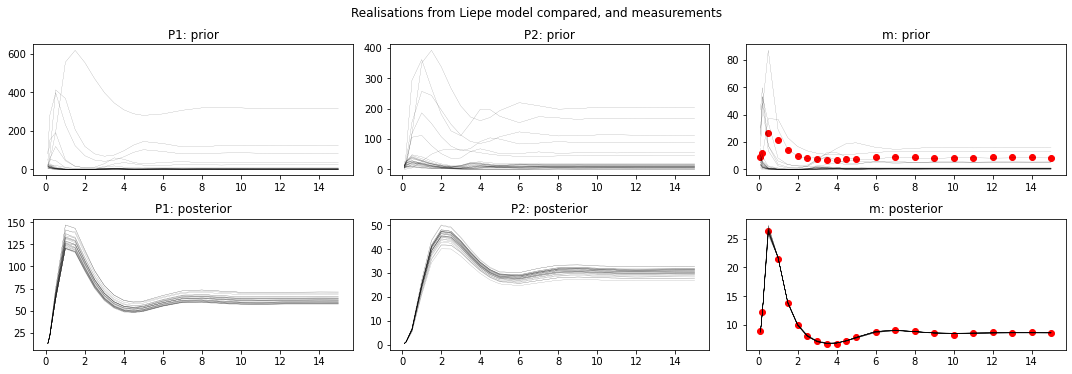

In [7]:
def plot_timecourses(idata_prior: az.InferenceData, idata_posterior: az.InferenceData):
    """Function that plots timecourses for a prior and posterior."""
    f, axes = plt.subplots(2, 3, figsize=[15, 5])
    for row, (idata_name, idata) in enumerate(
        zip(["prior", "posterior"], [idata_prior, idata_posterior])
    ):
        conc_draws = (
            idata.posterior["conc"]
            .to_series()
            .unstack(["species", "time"])
            .sort_index(axis=1)
        )
        species = conc_draws.columns.levels[0].values
        times = conc_draws.columns.levels[1].values
        for (chain, draw), _ in conc_draws.sample(30).iterrows():
            for col, s in enumerate(species):
                t = conc_draws.loc[(chain, draw), s]
                ax = axes[row, col]
                ax.plot(t.index, t.values, linewidth=0.1, label=s, color="black")
                ax.set_title(f"{species[col]}: {idata_name}")
        axes[row,-1].scatter(times, idata.observed_data["y_m"].values, color="red")
    f.tight_layout()
    return f

print("Average prior log likelihood: " + str(float(liepe_prior.log_likelihood["llik"].mean())))
print("Average posterior log likelihood: " + str(float(liepe_posterior.log_likelihood["llik"].mean())))

f_tcs = plot_timecourses(liepe_prior, liepe_posterior)
suptitle = f_tcs.suptitle("Realisations from Liepe model compared, and measurements", y=1.03)
f_tcs.savefig(os.path.join("results", "plots", "timecourses_liepe.png"))

From this plot it is possible to discern two problems with the model. First, the realised timecourses from the prior model do not match the observed data very well. This impression is supported by the very low average prior log likelihood. Second, the posterior model seems to overfit the observed data, with almost all realised timecourses achieving an unrealistically tight fit to the simulated measurements.

Comparing the bottom right plot of $m$ timecourses with an equivalent plot from the original analysis highlights the advantage of a model with an explicit likelihood function over ABC:

<div>
<img src="./data/raw/timecourse.png" width="500"/>
</div>

First, the realised timcourses in the reproduced analysis are much smoother than those in the original analysis. It is not clear why the timecourses in the original analysis are jagged, as the underlying kinetic model would be expected to produce smooth timecourses.

Second, the use of ABC rather than an explicit measurement model obscured the fact that the original analysis used an exact simulated timecourse as measurements, effectively assuming that species $m$ was measured without any error. In a model with an explicit likelihood function, this choice of data naturally leads to an unrealistically low estimate of the measurement error parameter $\sigma$, and timecourses that tightly hew to the simulated measurements. In the ABC model, in contrast, there is no measurement error parameter, so the model does not respond appropriately to the very regular data.

## Improved model

To recap, we have implemented a fully Bayesian version of the original analysis and observed three problems:

1. The prior model does not converge and exhibits post-warmup divergent transitions
2. The prior model does not rule out some unrealistic timecourses
3. The measurements were simulated with no noise, leading to a posterior model with an unrealistically tight fit.

To address problems 1. and 2., we replace the wide uniform prior distributions in the original analysis with somewhat narrower lognormal distributions. To address problem 3, we assume a true value of 0.2 for the measurement error parameter $\sigma$ and generate simulated measurements taking this error into account. As a further improvement we also let the parameter $p_4$ vary rather than assuming it is known to be exactly 1.

The priors are set by choosing the 1% and 99% quantiles of a lognormal distribution. This implies that, according to the prior model, the probability of the true value lying outside the specified range in each direction is 1%. the chosen quantiles are shown below, alongside the true values used to generate the data:

|param| 1% quantile | 99% quantile | true_value |
|-----|-------------|--------------|------------|
|$p_0$|0.1|20|10|
|$p_1$|0.1|3|0.5|
|$p_2$|0.1|20|10|
|$p_3$|0.1|4|2|
|$p_4$|0.1|2|1|
|$\sigma$|0.01|0.8|0.2|

As well as leading to better computational performance by avoiding the sharp boundaries of the previous model, this prior model is likely a better reflection of the available information in a real setting. It is very unusual for real parameter values to be known with sharp boundaries, whereas knowledge that a parameter is _almost_ certainly greater or less than a certain value is more typical. It is also typical for central parameter values to be more plausible than extreme values, which our method also achieves.


The improved model's code is shown below:

In [8]:
!cat src/stan/lognormal.stan

/* Model with lognormal priors */
functions {
#include custom_functions.stan
}
data {
  int<lower=1> N;
  int<lower=1> N_train;
  int<lower=1> N_test;
  array[2] vector[5] p_loc_and_scale;
  array[2] real sigma_loc_and_scale;
  vector[N] y_m;
  array[N] real sim_times;
  array[N_train] int<lower=1,upper=N> ix_train;
  array[N_test] int<lower=1,upper=N> ix_test;
  int<lower=0,upper=1> likelihood;
}
transformed data {
  matrix[3, 7] S = [[-1, 0, 1, 0, 0,-1,-1],
                    [ 1,-1, 0, 0,-1, 0, 0],
                    [ 0, 1, 0,-1, 0, 0, 0]];
  vector[3] conc_init = [10, 5, 0]';
  real t_init = 0;
  real abstol = 1e-12;
  real reltol = 1e-12;
  int steps = 1000000;
}
parameters {
  real<lower=0> sigma;
  vector<lower=0>[5] p;
}
transformed parameters {
  array[N] vector[3] conc =
    ode_bdf_tol(dPdt, conc_init, t_init, sim_times, abstol, reltol, steps, S, p);
}
model {
  sigma ~ lognormal(sigma_loc_and_scale[1], sigma_loc_and_scale[2]);
  p ~ lognormal(p_loc_and_scale[1], p_loc_an

The next cell loads the results of the lognormal model and plots them in the same way as before.

Lognormal prior summary:


/Users/tedgro/Code/mrna/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.241,0.155,0.045,0.515,0.005,0.004,1448.0,529.0,1.010000e+00
p[p0],10.597,3.280,5.291,16.964,0.098,0.081,1379.0,586.0,1.000000e+00
p[p1],0.706,0.549,0.097,1.555,0.017,0.014,1431.0,596.0,1.010000e+00
p[p2],10.448,3.166,5.236,16.587,0.092,0.073,1381.0,603.0,1.000000e+00
p[p3],1.974,0.647,0.951,3.205,0.021,0.015,911.0,519.0,1.000000e+00
p[p4],0.852,0.365,0.333,1.543,0.011,0.009,1249.0,695.0,1.010000e+00
lp,-8.495,1.720,-11.388,-5.812,0.083,0.059,464.0,489.0,1.000000e+00
acceptance_rate,0.900,0.115,0.675,1.000,0.007,0.005,997.0,199.0,1.020000e+00
step_size,0.791,0.083,0.683,0.891,0.041,0.031,4.0,4.0,5.388524e+15
tree_depth,2.622,0.488,2.000,3.000,0.049,0.035,90.0,116.0,1.040000e+00


Lognormal posterior summary


/Users/tedgro/Code/mrna/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.209,0.034,0.147,0.273,0.002,0.001,517.0,412.0,1.020000e+00
p[p0],9.172,2.475,5.341,14.043,0.100,0.072,617.0,419.0,1.000000e+00
p[p1],0.441,0.120,0.233,0.667,0.006,0.004,404.0,446.0,1.010000e+00
p[p2],9.306,0.934,7.656,11.229,0.040,0.028,537.0,460.0,1.010000e+00
p[p3],1.966,0.688,0.951,3.092,0.038,0.030,441.0,409.0,1.010000e+00
p[p4],0.937,0.104,0.746,1.116,0.004,0.003,618.0,472.0,1.000000e+00
lp,-3.211,2.050,-6.899,-0.197,0.114,0.081,322.0,419.0,1.000000e+00
acceptance_rate,0.925,0.109,0.733,1.000,0.004,0.003,822.0,809.0,1.010000e+00
step_size,0.104,0.013,0.090,0.124,0.006,0.005,4.0,4.0,5.969253e+15
tree_depth,4.881,0.608,4.000,6.000,0.024,0.030,159.0,800.0,1.030000e+00


Average prior log likelihood: -31.759651842215906
Average posterior log likelihood: -2.13983780875


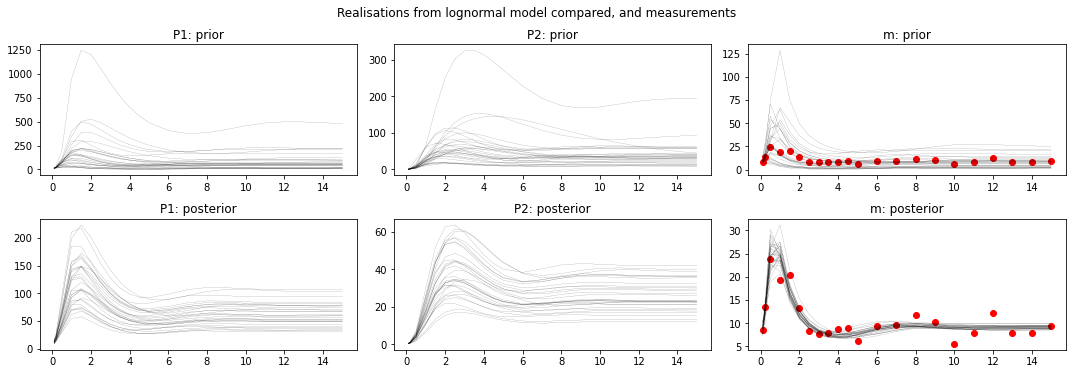

In [9]:
from IPython.display import display

ln_prior, ln_posterior = (
    az.from_json(os.path.join(RESULTS_DIR, "lognormal", f))
    for f in ["prior.json", "posterior.json"]
)
print("Lognormal prior summary:")
display(pd.concat([
    az.summary(ln_prior, var_names=["sigma", "p"]),
    az.summary(ln_prior.sample_stats)
]))

print("Lognormal posterior summary")
display(pd.concat([
    az.summary(ln_posterior, var_names=["sigma", "p"]),
    az.summary(ln_posterior.sample_stats)
]))

print("Average prior log likelihood: " + str(float(ln_prior.log_likelihood["llik"].mean())))
print("Average posterior log likelihood: " + str(float(ln_posterior.log_likelihood["llik"].mean())))


f_tcs = plot_timecourses(ln_prior, ln_posterior)
suptitle = f_tcs.suptitle("Realisations from lognormal model compared, and measurements", y=1.03)
f_tcs.savefig(os.path.join("results", "plots", "timecourses_lognormal.png"))

From these results it is clear that the problems we observed in the previous model have been addressed: the prior model has converged and exhibits no post-warmup divergent transitions, the realised prior timecourses match the data much better and the posterior is more realistic thanks to the use of measurements generated with noise.

## Conclusion

This analysis has shown that it is possible to replicate and improve on an ABC analysis of an mrna regulation system using a fully Bayesian statistical model implemented with Stan.